<파이썬 머신러닝 완벽 가이드 개정 2판> 8장 p.566 - 583

# CHAPTER 08. 텍스트 분류
---
## 08-10. 텍스트 분석 실습 - 캐글 Mercai Price Suggestion Challenge
#### 1. 데이터 전처리
#### 2. 피처 인코딩과 피처 벡터화
#### 3. 릿지 회귀 모델 구축 및 평가
#### 4. LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. 데이터 전처리


In [ ]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('/content/drive/MyDrive/ESAA_OB/Dataset/train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [ ]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


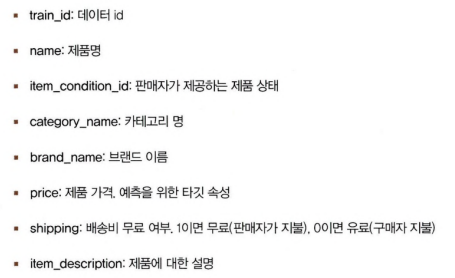

#####**price**

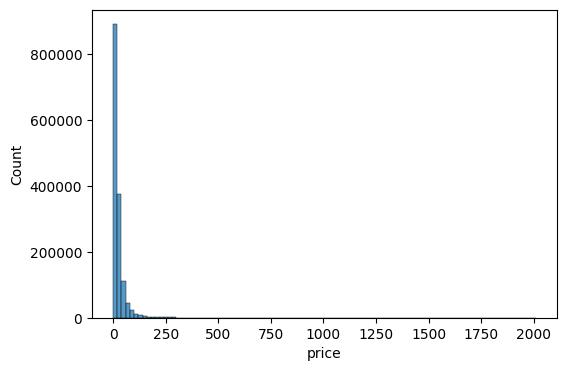

In [ ]:
# 타깃 값인 price 칼럼의 데이터 값 분포도 확인
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize=(6, 4))
sns.histplot(y_train_df, bins=100)
plt.show()

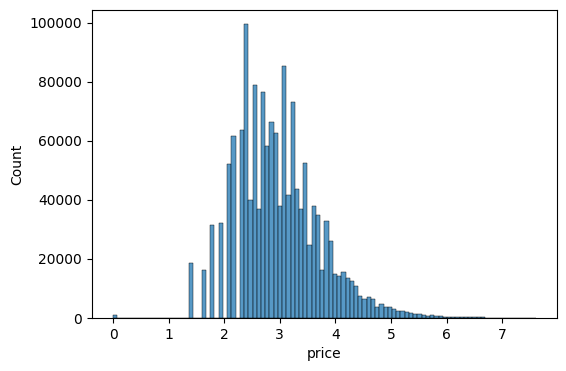

In [ ]:
# price 값이 비교적 적은 가격을 가진 데이터 값에 왜곡되어 분포해 있으므로 로그값으로 변환한 뒤 그 분포도를 살펴보기
import numpy as np

y_train_df = np.log1p(y_train_df)
plt.figure(figsize=(6, 4))
sns.histplot(y_train_df, bins=100)
plt.show()

In [ ]:
# 데이터 세트의 price 칼럼을 원래 값에서 로그로 변환된 값으로 변경
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

,price
0,2.397895
1,3.970292
2,2.397895


#####**item_condition_id**

In [ ]:
# 범주형 피처인 shipping, iterm_condition_id 칼럼들의 유형 살피기
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('iterm_condition_id 값 유형: \n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 shipping
0    819435
1    663100
Name: count, dtype: int64
iterm_condition_id 값 유형: 
 item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64


In [ ]:
# item_description 칼럼에서 'No description yet'값이 얼마나 있는지 확인
boolean_condition = mercari_df['item_description'] == 'No description yet'
print(mercari_df[boolean_condition]['item_description'].count())

82489


#####**category_name**

In [ ]:
# category_name이 Null이 아닌 경우에 split('/')를 이용해 대, 중, 소 분류를 분리하는 함수 생성

# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성. 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other_Null', 'Other_Null', 'Other_Null']

# 위의 split_cat()을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

In [ ]:
# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형: \n', mercari_df['cat_dae'].value_counts())
print('중분류 유형: \n', mercari_df['cat_jung'].nunique())
print('소분류 유형: \n', mercari_df['cat_so'].nunique())

대분류 유형: 
 cat_dae
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: count, dtype: int64
중분류 유형: 
 114
소분류 유형: 
 871


In [ ]:
# brand_name, category_name, item_description 칼럼의 Null 값을 일괄적으로 'Other_Null'로 동일하게 변경
mercari_df['brand_name']= mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

In [ ]:
# 각 칼럼별로 Null 값의 건수 확인
mercari_df.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,0
brand_name,0
price,0
shipping,0
item_description,0
cat_dae,0
cat_jung,0


### 2. 피처 인코딩과 피처 벡터화
1.  피처 인코딩
   - 범주형 칼럼(brand_name, item_condition_id, shipping, cat_dae, cat_jung, cat_so)
   - LabelBinarizer을 이용
   - 원-핫 인코딩
2. 피처 벡터화
   - 짧은 텍스트의 칼럼(name)
      - Count 기반의 벡터화
      - CountVectorizer 적용
   - 긴 텍스트 칼럼(item_description)
      - TD-IDF 기반 벡터화
      - TdidfVectorizer 적용
3. scipy.sparse의 hstack을 이용해 모든 희소행렬을 결합
4. 추후 모델링: 선형 회귀, 회귀 트리 모델 모두 적용


In [ ]:
# brand_name이 어떤 유형으로 되어있는지 유형 건수와 대표적인 브랜드명 5개 확인
print('brand name의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건:\n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수 : 4810
brand name sample 5건:
 brand_name
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: count, dtype: int64


In [ ]:
# name이 어떤 유형으로 되어있는지 유형건수와 대표적인 이름 7개 확인
print('name의 유형 건수:', mercari_df['name'].nunique())
print('name의 sample 5건: \n', mercari_df['name'].value_counts()[:7])

name의 유형 건수: 1225273
name의 sample 5건: 
 name
Bundle                 2232
Reserved                453
Converse                445
BUNDLE                  418
Dress                   410
Coach purse             404
Lularoe TC leggings     396
Name: count, dtype: int64


In [ ]:
# item_description의 평균 문자열 크기와 2개 정도의 텍스트 추출
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열의 크기:', mercari_df['item_description'].str.len().mean())  # len()의 대상은 str(문자열) 타입이어야 함.

mercari_df['item_description'][:2]

item_description 평균 문자열의 크기: 145.71139703278507


,item_description
0,No description yet
1,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.


#####**피처 벡터화**

In [ ]:
# name 속성에 대한 Count 기반 피처 벡터화 변환
cnt_vct = CountVectorizer()
X_name = cnt_vct.fit_transform(mercari_df['name'])

# item_description 속성에 대한 TF-IDF 기반 피처 벡터화 변환
tfidf_vct = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_vct.fit_transform(mercari_df['item_description'])

In [ ]:
print('name vectorization shape:', X_name.shape)
print('item description shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item description shape: (1482535, 50000)


- 인코딩 변환된 데이터 세트들의 타입: CSR 형태의 csr_matrix 타입
- brand_name 칼럼 값의 유형이 4810개 --> 원핫 인코딩 된 X_brand의 인코딩 칼럼이 4810개


#####**피처 인코딩**

In [ ]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [ ]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


#####**데이터 세트 결합**

In [ ]:
# 피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트를 모두 결합
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


0

- 결합된 데이터 세트 역시 csr_matrix 타입
- 총 161569개의 피처를 가짐.

### 3. 릿지 회귀 모델 구축 및 평가
- 평가 기준: RMSLE (Root Mean Square Logarithmic Error)


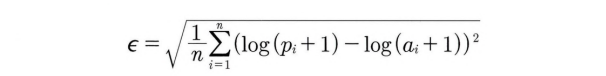

- 시도 모델: Ridge, LGBM, 앙상블

In [ ]:
# rmsle 계산 함수
def rmsle(y, y_pred):
  # underflow, overflow를 막기 위해 log가 아닌 lop1p로 rmsle 계산
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

In [ ]:
# 역변환된 데이터를 기반으로 RMSLE를 적용할 수 있도록 평가 함수
def evaluate_org_price(y_test, preds):
  # 원본 데이터는 log1p로 변환되었으므로 expm1로 원복 필요
  preds_exmpm = np.expm1(preds)
  y_test_exmpm = np.expm1(y_test)

  # rmsle로 RMSLE값 추출
  rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
  return rmsle_result

In [ ]:
# model 인자로 사이킷런의 회귀 estimator 객체를, matrix_list 인자로
# 최종 데이터 세트로 결합한 희소 행렬 리스트를 가지는 모델 학습/예측 함수
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
  # scipy.sparse 모듈의 hstack를 이용해 희소 행렬 결합
  X = hstack(matrix_list).tocsr()

  X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'],
                                                      test_size=0.2, random_state=156)

  # 모델 학습 및 예측
  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  del X, X_train, y_train
  gc.collect()

  return preds, y_test

In [ ]:
# 예측 수행 전 Mercari 상품 가격 예측에 item_description과 같은 텍스트 형태의 속성이 얼마나 영향을 미치는지 확인
linear_model = Ridge(solver='lsqr', fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(linear_model, sparse_matrix_list)
print('Item Description을 제외한 rmsle 값:', evaluate_org_price(linear_preds, y_test))

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, X_descp, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(linear_model, sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:', evaluate_org_price(linear_preds, y_test))

Item Description을 제외한 rmsle 값: 0.4983990938999374
Item Description을 포함한 rmsle 값: 0.4680804651494449


- item_description 포함 후 rmsle 값이 많이 감소. 영향을 꽤 미침.

### 4. LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

In [ ]:
# LightGBM으로 회귀 수행
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)

print('LightGBM rmsle 값:', evaluate_org_price(y_test, lgbm_preds))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1276.680556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1068323
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 65338
[LightGBM] [Info] Start training from score 2.979514


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM rmsle 값: 0.4650417323016895


In [ ]:
# 릿지 결괏값에 0.45를 곱하고 LGBM 결괏값에 0.55를 곱한 값을 합해 최종 앙상블 예측값 생성
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 rmsle 값:', evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 ensemble한 rmsle 값: 0.4505980717907366
